In [55]:
%pip install matplotlib
%pip install pandas
%pip install scipy
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 25.9 MB 6.3 MB/s eta 0:00:01     |█████████████████████████████▎  | 23.6 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 33.4 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1308 sha256=e8fac0f4f4f9155ab30ee04ead92113d0874e96fac111f24cf17a545741e5c89
  Stored in directory: /home/vgomez/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import calendar
from scipy import integrate

In [8]:
available_parkings = ['QuatreCamins_Estable', 'SantSadurni_Estable', 'SantBoi_Estable', 'Vilanova_Estable', 'quatrecamins']
current_parking = available_parkings[0]
df = pd.read_csv('data/'+current_parking+".csv", delimiter=";")
df = df.dropna()
df = df.reset_index(drop=True)
df.head(6)

,DateTime,Parking Quatre Camins plazas totales
0,01/01/2020 0:00,"107,7378322"
1,01/01/2020 0:30,"106,9062389"
2,01/01/2020 1:00,"106,5981128"
3,01/01/2020 1:30,107
4,01/01/2020 2:00,107
5,01/01/2020 2:30,107


# Data processing and preliminary analysis

In [11]:
def getDayName(d):
    return calendar.day_name[d.weekday()]

available_parkings = ['QuatreCamins_Estable', 'SantSadurni_Estable', 'SantBoi_Estable', 'Vilanova_Estable', 'quatrecamins']
current_parking = available_parkings[0]
df = pd.read_csv('data/'+current_parking+".csv", delimiter=";")
df = df.dropna()
df['Date'] = df['DateTime'].apply(lambda x: x.split(' ')[0])
df['Time'] = df['DateTime'].apply(lambda x: x.split(' ')[1])
df['Free slots'] = df['Parking Quatre Camins plazas totales'].apply(lambda x: int(x.split(',')[0]))
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df.sort_values(by="Date")
df['Weekday'] = df.apply(lambda x: getDayName(x['Date']),axis=1)
df['Date'] = [d.date().strftime("%Y-%m-%d") for d in df['Date']]
df = df.drop(['DateTime'], axis=1)
df = df.drop(['Parking Quatre Camins plazas totales'], axis=1)

max_value = df["Free slots"].max()
min_value = df["Free slots"].min()
df['Occupancy'] = df['Free slots'].map(lambda x: max_value-x)
axis_ylim = max_value+20
axis_ylim_low = 0
print('Y lim: ' ,axis_ylim)
df.head()

Y lim:  178


,Date,Time,Free slots,Weekday,Occupancy
0,2020-01-01,0:00,107,Wednesday,51
1,2020-01-01,0:30,106,Wednesday,52
2,2020-01-01,1:00,106,Wednesday,52
3,2020-01-01,1:30,107,Wednesday,51
4,2020-01-01,2:00,107,Wednesday,51


In [12]:
# GLOBAL VARIABLES THAT MUST BE FILLED ALONG THE Jup. NOTEBOOK FOR THE EXPORT
max_capacity = max_value

hist_weekday_proto = []
hist_friday_proto  = []
hist_weekend_proto = []

gammix_weekday_pars = []
gammix_friday_pars  = []
gammix_weekend_pars = []

gammix_weekday_proto = []
gammix_friday_proto  = []
gammix_weekend_proto = []

time = np.linspace(0,23.5,48)

### Delete days that have not to be taken into account

In [13]:
days_list = ['2020-01-01', '2020-01-06', '2020-02-07', '2020-02-23', 
             '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
             '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-02-29',
             '2020-01-19']

#days_list = ['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06', '2020-02-06', '2020-02-07', '2020-02-23', '2020-02-28', 
#             '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
#             '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-02-29',
#             '2020-01-19']

def checkDataValidty(date):
    if date in days_list: 
        return False
    else:
        return True

In [14]:
df['Stable Data'] = df['Date'].apply(lambda x: checkDataValidty(x))
df_holidays = df[df['Stable Data'] == False]
df = df[df["Stable Data"] == True]

## Mean free slots by weekday

In [15]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_days = df.groupby([df['Weekday']], as_index=False).mean()

# REORDER BY DAY
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = df_days['Weekday'].map(mapping)
df_days = df_days.iloc[key.argsort()]
df_days.reset_index(inplace=True, drop=True) 

#df_bla = df.groupby('Weekday').agg({'score': ['mean', 'std']})

In [16]:
# cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# # esta bien esto?
# df_days = df.groupby('Weekday').agg({'Occupancy': ['mean', 'std']})
# # df_days = df.groupby('Weekday').agg({'Occupancy': ['mean', 'std']})

# # REORDER BY DAY
# days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
# mapping = {day: i for i, day in enumerate(days)}
# df_days.reset_index(inplace=True, drop=False) 
# key = df_days['Weekday'].map(mapping)
# df_days = df_days.iloc[key.argsort()]
# df_days.reset_index(inplace=True, drop=True) 
# means = df_days['Occupancy']['mean']
# stds = df_days['Occupancy']['std']
# df

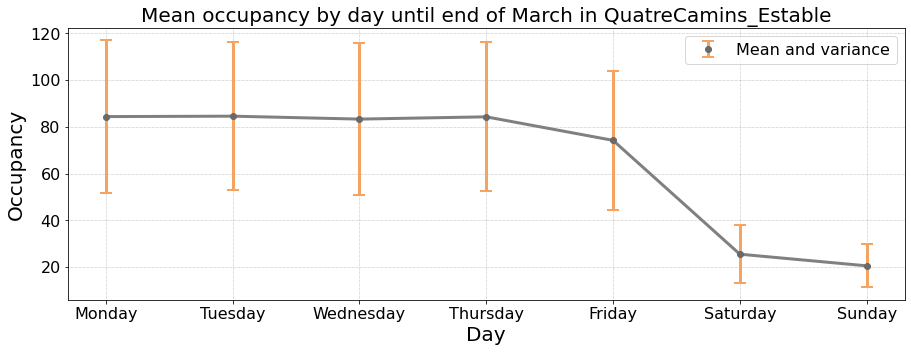

In [17]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_days_ = df.groupby('Weekday').agg({'Occupancy': ['mean', 'std']})
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
df_days_.reset_index(inplace=True, drop=False) 
key = df_days_['Weekday'].map(mapping)
df_days_ = df_days_.iloc[key.argsort()]
df_days_.reset_index(inplace=True, drop=True) 
means = df_days_['Occupancy']['mean']
stds = df_days_['Occupancy']['std']

x = df_days_['Weekday']
y = means
err = stds
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(x,y, color='grey',  linewidth=3)
plt.errorbar(x, y,
            xerr=None,
            yerr=err/2, fmt='o',color='dimgray',label="Mean and variance",
             ecolor='sandybrown', elinewidth=3, capsize=6, capthick=2)
plt.title('Mean occupancy by day until end of March in '+current_parking, fontsize=20)
plt.xlabel('Day', fontsize = 20)
plt.ylabel('Occupancy', fontsize = 20)
plt.legend(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
df = df.reset_index(drop = True)

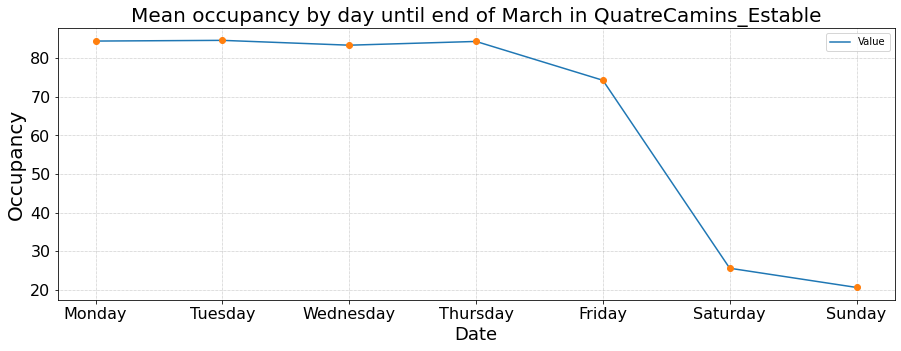

In [18]:
x = df_days['Weekday']
y = df_days['Occupancy']
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(x,y, label='Value')
plt.plot(x,y,'o')
plt.title('Mean occupancy by day until end of March in '+current_parking, fontsize=20)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Occupancy', fontsize = 20)
plt.legend()
# changing the fontsize of yticks
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
# plt.xticks(fonstize=14)
plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
df = df.reset_index(drop = True)

In [19]:
df_days['Occupancy']

0    84.407407
1    84.590437
2    83.337500
3    84.308712
4    74.250000
5    25.585417
6    20.611111
Name: Occupancy, dtype: float64

## Compute the mean for different days

In [20]:
def toAbsHour(hour):
    beginning = [int(s) for s in hour.split(':')]
    absol_hour = (beginning[0] + beginning[1]/60 )
    return absol_hour

df_byhour = df
df_byhour['ABS_Hour'] = df_byhour['Time'].apply(lambda x: toAbsHour(x) )

df_hours = df_byhour
df_hours['hour'] = df_hours['ABS_Hour'].map(lambda x: (int(2*x))/2)


# Normalization

In [21]:
def Area_by_date(date):
    df_day = df[(df['Date'] == date)]
    Profile = df_day['Occupancy'].values
    Area = integrate.simps(Profile)
    return Area

df_hours['Area'] = df_hours['Date'].apply(lambda x: Area_by_date(x))

def df_normalization(occ, area):
    if area == 0:
        return 'error'
    return occ/area

df_hours['Normalized_occupancy'] = df_hours.apply(lambda x: df_normalization(x.Occupancy, x.Area), axis=1)

#df_hours = df_hours.drop(['Occupancy'], axis=1)
#df_hours['Occupancy'] = df_hours['Normalized_occupancy'].apply(lambda x: x)
df_mean_slots = df_hours.groupby(by=['Weekday','hour'], axis = 0, group_keys=True).mean()

In [22]:
mean_occupancy = df_mean_slots['Occupancy']

In [23]:
Monday_occ = mean_occupancy['Monday']
Tuesday_occ = mean_occupancy['Tuesday']
Wednesday_occ = mean_occupancy['Wednesday']
Thursday_occ = mean_occupancy['Thursday']
Friday_occ = mean_occupancy['Friday']
Saturday_occ = mean_occupancy['Saturday']
Sunday_occ = mean_occupancy['Sunday']

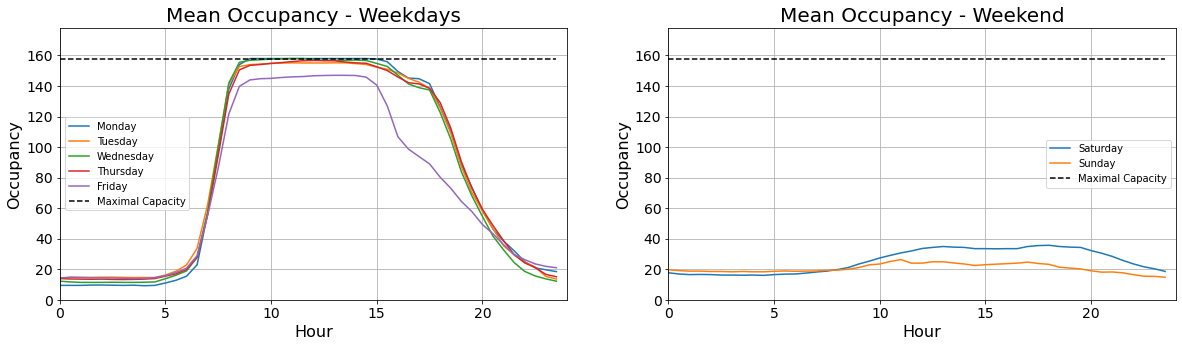

In [24]:
fig = plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
maximal_line = np.zeros(48)+max_value;
time=np.linspace(0,23.5,48);


plt.plot(Monday_occ,label='Monday')
plt.plot(Tuesday_occ,label='Tuesday')
plt.plot(Wednesday_occ,label='Wednesday')
plt.plot(Thursday_occ, label='Thursday')
plt.plot(Friday_occ,label='Friday')
plt.plot(time, maximal_line,'--',color='black',label='Maximal Capacity')

plt.title('Mean Occupancy - Weekdays', fontsize=20)
plt.xlabel('Hour', fontsize=16); plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(labelsize=14)
plt.axis([0, 24, 0, axis_ylim])
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(Saturday_occ,label='Saturday')
plt.plot(Sunday_occ,label='Sunday')
plt.plot(time, maximal_line,'--',color='black',label='Maximal Capacity')

plt.title('Mean Occupancy - Weekend', fontsize=20)
plt.xlabel('Hour', fontsize=16); plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(labelsize=14)
plt.axis([0, 24, 0, axis_ylim])
plt.legend()
plt.grid()

## Variance computation

In [25]:
def mean_day(Weekday,date):
    df = df_hours[(df_hours['Weekday'] == Weekday)]
    df_day = df[(df['Date'] == date)]
    df_day_mean = df_day.groupby(by=['Weekday','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    Day = mean_free_slots[Weekday]
    return Day

def generate_mean_variance(accumulated_date, accumulated_free_slots):
    aux_dict = {};
    for ii in np.arange(len(accumulated_date)):
        free_slots = list(accumulated_free_slots[ii].iat)
        hour = list(accumulated_free_slots[ii].index)
        for jj in np.arange(len(free_slots)):
            current_hour = hour[jj]
            if current_hour not in aux_dict:
                aux_dict[current_hour] = []
            aux_dict[current_hour].append(free_slots[jj])
    return aux_dict

def compute_mean_variance(aux_dict):
    domain = np.linspace(0,23,47)
    var_vec = []; mean_vec = []; hour_vec=[];
    for ii in domain:
        if ii in aux_dict:
            var_vec.append(np.var(list(aux_dict[ii])))
            mean_vec.append(np.mean(list(aux_dict[ii])))
            hour_vec.append(ii)
    return var_vec, mean_vec, hour_vec

### Visualize days

48
48
48
48
48
48
48
48
48


Text(0.5, 0, 'Time [h], 0.5 step ')

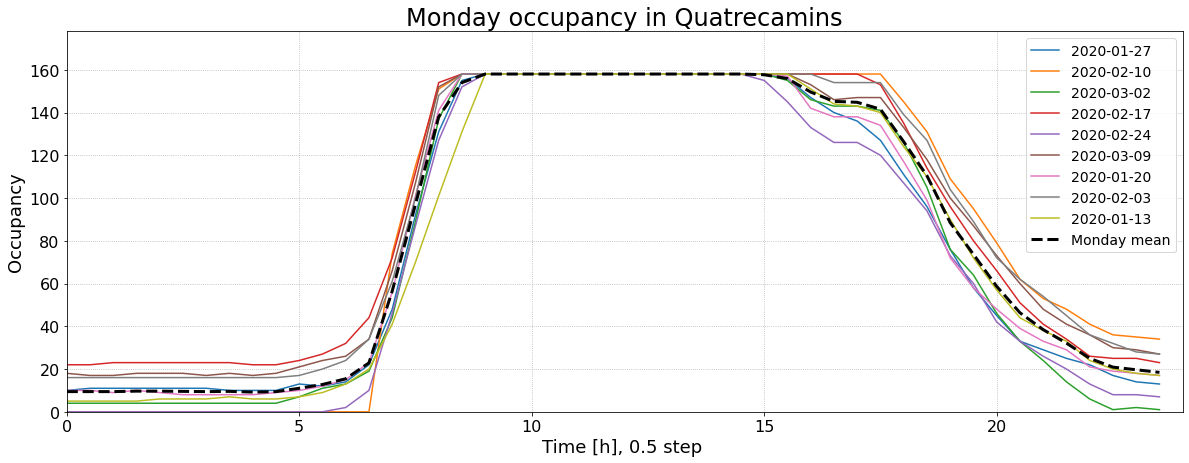

In [26]:
Weekday = 'Monday'
Day_df = df_hours[(df_hours['Weekday'] == Weekday)]
dates = Day_df['Date']
dates_options = set(dates[:][:])
dates_options = list(dates_options)
lockdown_dates=[];
#lockdown_dates.append('06/01/2020')
# lockdown_dates.append('16/01/2020')
# lockdown_dates.append('30/01/2020')
# lockdown_dates.append('23/01/2020')

fig = plt.figure(figsize = (20,7))
accumulated_free_slots=[];
accumulated_date=[];

for ii in np.arange(len(dates_options)):
    day = dates_options[ii]
    Day = mean_day(Weekday,day)
    aux_vec=np.zeros(24)
    Day_list = list(Day)
    accumulated_date.append(day)
    accumulated_free_slots.append(Day)
    plt.plot(Day,label=day)
    print(len(Day.values))
    
label_tag = Weekday + ' mean'
plt.title('Monday occupancy in Quatrecamins', fontsize=24)
plt.plot(Monday_occ,'--', color='black', label = label_tag, linewidth=3)
plt.axis([0, 24, axis_ylim_low, axis_ylim])
plt.grid(linestyle='dotted')
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Occupancy', fontsize=18)
plt.xlabel('Time [h], 0.5 step ', fontsize=18)

# PREDICTION 

### Prepare the data for the prediction

In [27]:
def classify_2_proto(x):
    weekday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    if x in weekday_list:
        return 'Weekday'
    else:
        return 'Weekend'


def classify_3_proto(x):
    weekday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']
    weekend_list = ['Saturday', 'Sunday']
    if x in weekday_list:
        return 'Weekday'
    elif x in weekend_list:
        return 'Weekend'
    else:
        return 'Friday'
    

# 1 week data = 336 rows (48*7) WE ASUME WE HAVE COMPLETE DATA WITHOUT GAPS BETWEEN HOURS, AND DATA FROM 0.0 TO 23.5
# @from_end: if the testing data is retrieved from the last part of the df or from th beginning. By default, from the end
# @limit_date: if we want to get the train from specific date instead of by number of weeks

def split_data(df, n_test_weeks, limit_date = None, from_end=True): 
    if(limit_date != None):
        init_test = df[df['Date']==limit_date].index[0];
        end_test = df.shape[0]
        test_domain = range(init_test, end_test)
        test_domain = list(test_domain)

    else:
        if(from_end == True):
            end_test = df.shape[0]
            week_domain = n_test_weeks*336
            init_test = end_test-week_domain
            test_domain = range(init_test, end_test)
            test_domain = list(test_domain)
            
        elif(from_end == False):
            week_domain = n_test_weeks*336
            init_test = 0
            end_test = week_domain
            test_domain = range(0,week_domain)
            test_domain = list(test_domain)
            
    test_df = df[init_test:end_test]
    training_df = df.drop(test_domain)
    return training_df, test_df

In [28]:
df_byhour['MonthNumber']= df_byhour['Date'].apply(lambda x: x.split('-')[1])
df_prediction_mean = df_byhour.groupby(by=['Date','hour','MonthNumber','Weekday'], axis = 0, as_index=False).mean()
df_prediction_mean['Profile_2'] = df_prediction_mean['Weekday'].apply(lambda x: classify_2_proto(x))
df_prediction_mean['Profile_3'] = df_prediction_mean['Weekday'].apply(lambda x: classify_3_proto(x))

### Split data in Training/Testing df

In [29]:
number_of_testing_weeks = 3
df_training, df_testing = split_data(df_prediction_mean, number_of_testing_weeks)
df_train_data = df_training
df_train_data.head(5)
df_testing.head()

,Date,hour,MonthNumber,Weekday,Free slots,Occupancy,Stable Data,ABS_Hour,Area,Profile_2,Profile_3
2305,2020-02-22,0.5,02,Saturday,157.0,1.0,1.0,0.5,556.916667,Weekend,Weekend
2306,2020-02-22,1.0,02,Saturday,158.0,0.0,1.0,1.0,556.916667,Weekend,Weekend
2307,2020-02-22,1.5,02,Saturday,157.0,1.0,1.0,1.5,556.916667,Weekend,Weekend
2308,2020-02-22,2.0,02,Saturday,157.0,1.0,1.0,2.0,556.916667,Weekend,Weekend
2309,2020-02-22,2.5,02,Saturday,158.0,0.0,1.0,2.5,556.916667,Weekend,Weekend


## PREDICTION BY MEAN

In [30]:
def mean_day_profile(Profile, df_aux):
    df = df_aux[(df_aux['Profile_2'] == Profile)]
    df_day_mean = df.groupby(by=['Profile_2','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    Day = mean_free_slots[Profile]
    return Day

def mean_of_day(Weekday,date):
    df = df_hours[(df_hours['Weekday'] == Weekday)]
    df_day = df[(df['Date'] == date)]
    df_day_mean = df_day.groupby(by=['Weekday','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    Day = mean_free_slots[Weekday]
    return Day

# Get all days of the type (Monday, Tuesday...) and return the mean of them
def get_days(dayname, df_):
    data_temp = df_[df_['Weekday'] == dayname] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
        
    return days

def get_days_of_protos(proto_name, df_):
    data_temp = df_[df_['Profile_3'] == proto_name] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
        
    return days


In [31]:
# ------------------------ NEW TESTING DATA -----------------------------
# these variables are arrays of days
testing_mondays    = get_days("Monday", df_testing)
testing_tuesdays   = get_days("Tuesday", df_testing)
testing_wednesdays = get_days("Wednesday", df_testing)
testing_thursdays  = get_days("Thursday", df_testing)
testing_fridays    = get_days("Friday", df_testing)
testing_saturdays  = get_days("Saturday", df_testing)
testing_sundays    = get_days("Sunday", df_testing)

In [32]:
# a = [0,2,3,4,6]
# b = [1,1,1,1,1]
# c = np.array(a)+np.array(b)
# c/2

In [33]:
# ------------------------ TESTING DATA -----------------------------

real_monday = mean_of_day('Monday','2020-02-24')
real_tuesday = mean_of_day('Tuesday','2020-02-11')
real_wednesday = mean_of_day('Wednesday','2020-02-26')
real_thursday = mean_of_day('Thursday','2020-02-27')

################## Bad/None data on last Feb week ############################
real_friday = mean_of_day('Friday','2020-03-06') 
real_saturday= mean_of_day('Saturday','2020-03-07')
real_sunday = mean_of_day('Sunday','2020-03-01')

### 3 Prototypes: Weekday, Friday & Weekend

In [34]:
def mean_day_profile_3(Profile, df_aux):
    df = df_aux[(df_aux['Profile_3'] == Profile)]
    df_day_mean = df.groupby(by=['Profile_3','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    profile = mean_free_slots[Profile]
    return profile

In [35]:
# Obtain the 3 protoypes. IMPORTANT! We assume all the data in df is valid, robust and correct
def train_statistical_model(df): 
    df_day_mean = df.groupby(by=['Profile_3','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    return mean_free_slots['Weekday'], mean_free_slots['Friday'], mean_free_slots['Weekend'] 

weekdays = ['Monday', 'Thursday', 'Wednesday', 'Tuesday']
weekend= ['Saturday', 'Sunday']

# Simply return the proper prototype
def predict_full_day_statistical(day): 
    if day in weekdays: 
        return hist_weekday_proto
    elif day in weekend: 
        return hist_weekend_proto
    else:
        return hist_friday_proto


def get_proto_by_day(day_name):
    if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday']:
        return 
    return


def get_scale_factor(current_data, proto):
    index = len(current_data)
    proto_val = proto[index-1]
    last_hour_val = current_data[-1]
    scaling = last_hour_val/proto_val
    return scaling 


def predict_real_time(day, current_hour, current_value, max_capacity, pred_type):
    if pred_type == "Stat":
        proto = get_proto_by_day(day) #Get from statistical prototypes
    else: 
        scale_factor = get_scale_factor(current_value, proto_value)
        prediction = np.array(proto)*scale_factor
    return prediction


In [36]:
hist_weekday_proto, hist_friday_proto, hist_weekend_proto = train_statistical_model(df_train_data)
prediction = predict_full_day_statistical('Monday')

#### Plotting  prototypes

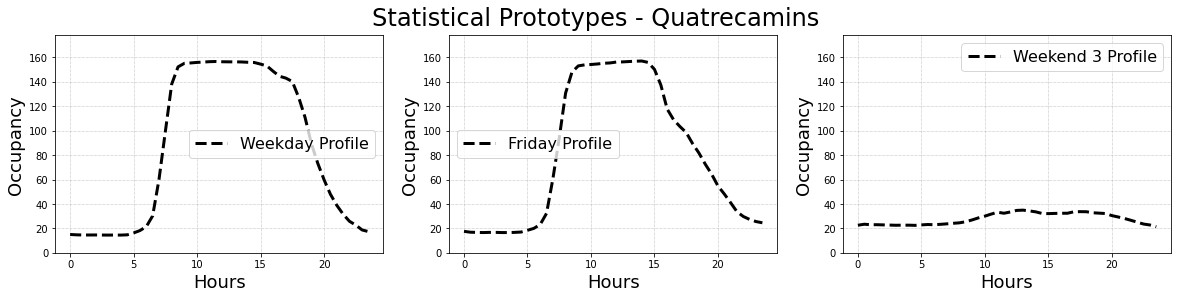

In [37]:
Weekday_proto = mean_day_profile_3('Weekday',df_train_data)
Weekend_proto = mean_day_profile_3('Weekend',df_train_data)
df_fri = df_train_data.drop(df_train_data[df_train_data['Date'] == '2020-02-07' ].index)
Friday_proto = mean_day_profile_3('Friday',df_fri)

fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Statistical Prototypes - Quatrecamins', fontsize=24)

ax[0].plot(hist_weekday_proto, linestyle='--', label='Weekday Profile', color='k', linewidth=3)
# ax[0].plot(real_monday.index.tolist(), real_monday.values.tolist(), label='Monday')
# ax[0].plot(real_tuesday.index.tolist(), real_tuesday.values.tolist(), label='Tuesday')
# ax[0].plot(real_wednesday.index.tolist(), real_wednesday.values.tolist(), label='Wednesday')
# ax[0].plot(real_thursday.index.tolist(), real_thursday.values.tolist(), label='Thursday')
ax[0].set_ylim([0,axis_ylim])
# ax[0].set_title("Weekday prototype")
ax[0].set_ylabel('Occupancy', fontsize=18)
ax[0].set_xlabel('Hours', fontsize=18)
ax[0].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[0].legend(fontsize=16)

ax[1].plot(hist_friday_proto, linestyle='--', label='Friday Profile', color='k', linewidth=3)
# ax[1].plot(real_friday.index.tolist(), real_friday.values.tolist(), label='Friday')
ax[1].set_ylim([0,axis_ylim])
# ax[1].set_title("Friday prototype")
ax[1].set_ylabel('Occupancy', fontsize=18)
ax[1].set_xlabel('Hours', fontsize=18)
ax[1].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[1].legend(fontsize=16)

ax[2].plot(hist_weekend_proto, linestyle='--', label='Weekend 3 Profile', color='k', linewidth=3)
# ax[2].plot(real_saturday.index.tolist(), real_saturday.values.tolist(), label='Saturday')
# ax[2].plot(real_sunday.index.tolist(), real_sunday.values.tolist(), label='Sunday')
ax[2].set_ylim([0,axis_ylim])
# ax[2].set_title("Weekend prototype")
ax[2].set_ylabel('Occupancy', fontsize=18)
ax[2].set_xlabel('Hours', fontsize=18)
ax[2].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[2].legend(fontsize=16)
# fig.tight_layout(pad=3.0)


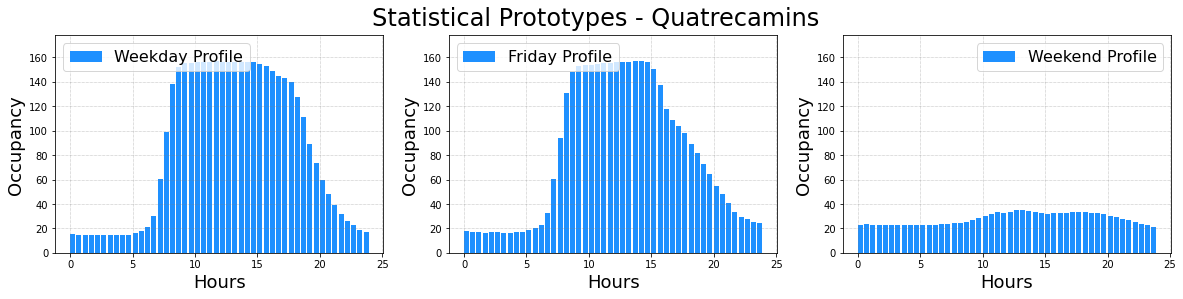

In [38]:
Weekday_proto = mean_day_profile_3('Weekday',df_train_data)
Weekend_proto = mean_day_profile_3('Weekend',df_train_data)
df_fri = df_train_data.drop(df_train_data[df_train_data['Date'] == '2020-02-07' ].index)
Friday_proto = mean_day_profile_3('Friday',df_fri)

fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Statistical Prototypes - Quatrecamins', fontsize=24)

ax[0].bar(hist_weekday_proto.index +0.2,hist_weekday_proto.values, width=0.4, label='Weekday Profile', color='dodgerblue', linewidth=3)
ax[0].set_ylim([0,axis_ylim])
# ax[0].set_title("Weekday prototype")
ax[0].set_ylabel('Occupancy', fontsize=18)
ax[0].set_xlabel('Hours', fontsize=18)
ax[0].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[0].legend(fontsize=16)

ax[1].bar(hist_friday_proto.index +0.2,hist_friday_proto.values, width=0.4, label='Friday Profile', color='dodgerblue', linewidth=3)
ax[1].set_ylim([0,axis_ylim])
# ax[1].set_title("Friday prototype")
ax[1].set_ylabel('Occupancy', fontsize=18)
ax[1].set_xlabel('Hours', fontsize=18)
ax[1].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[1].legend(fontsize=16)

ax[2].bar(hist_weekend_proto.index +0.2, hist_weekend_proto.values, width=0.4, label='Weekend Profile', color='dodgerblue', linewidth=3)

ax[2].set_ylim([0,axis_ylim])
# ax[2].set_title("Weekend prototype")
ax[2].set_ylabel('Occupancy', fontsize=18)
ax[2].set_xlabel('Hours', fontsize=18)
ax[2].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[2].legend(fontsize=16)
# fig.tight_layout(pad=3.0)


In [39]:
def subplot_training(fig, ax, xx, yy, proto_data, test_days, day, proto_name): 
    ax[xx,yy].plot(time, proto_data, linewidth=2.5, linestyle='dashed', label= proto_name + ' prediction')
    ax[xx,yy].legend(fontsize=16)
    for i in range(0, len(test_days)): 
        ax[xx, yy].plot(time, test_days[i], linewidth=0.75, label='Testing ' + day )
    ax[xx,yy].grid(linestyle='dotted')
    ax[xx,yy].set_ylim(0,axis_ylim)
    ax[xx,yy].set_xlabel('Time (hours)', fontsize=16)
    ax[xx,yy].set_ylabel('Occupancy', fontsize=16)

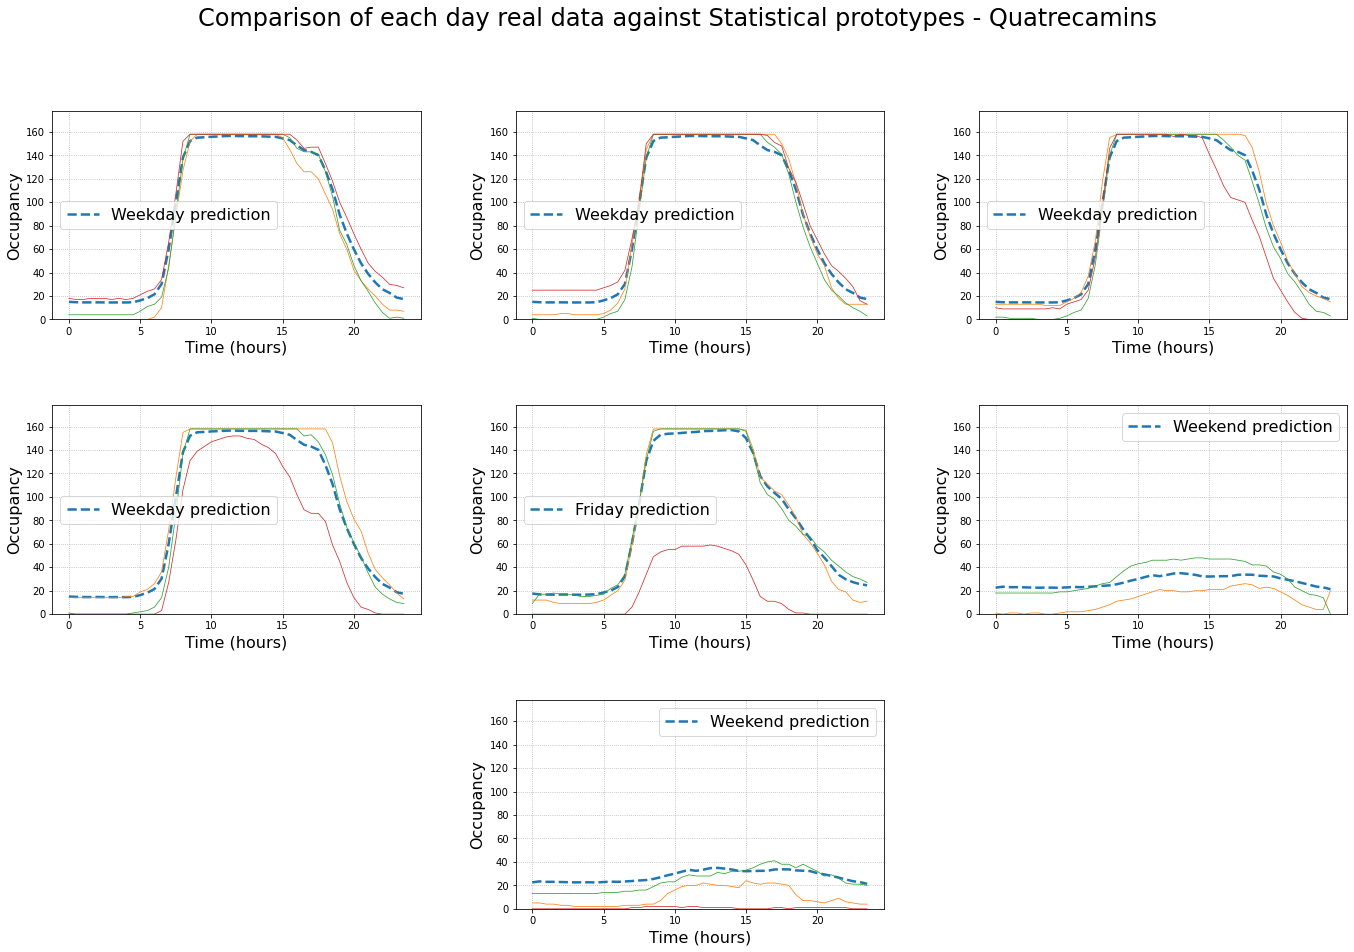

In [40]:
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(14)
fig.suptitle('Comparison of each day real data against Statistical prototypes - Quatrecamins', fontsize=24)

subplot_training(fig, ax, 0, 0, Weekday_proto.values, testing_mondays, 'Monday', 'Weekday')
subplot_training(fig, ax, 0, 1, Weekday_proto.values, testing_tuesdays, 'Tuesday', 'Weekday')
subplot_training(fig, ax, 0, 2, Weekday_proto.values, testing_wednesdays, 'Wednesday', 'Weekday')
subplot_training(fig, ax, 1, 0, Weekday_proto.values, testing_thursdays, 'Thursday', 'Weekday')
subplot_training(fig, ax, 1, 1, Friday_proto.values, testing_fridays, 'Friday', 'Friday')
subplot_training(fig, ax, 1, 2, Weekend_proto.values, testing_saturdays, 'Saturday', 'Weekend')
subplot_training(fig, ax, 2, 1, Weekend_proto.values, testing_sundays, 'Sunday', 'Weekend')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5)


(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

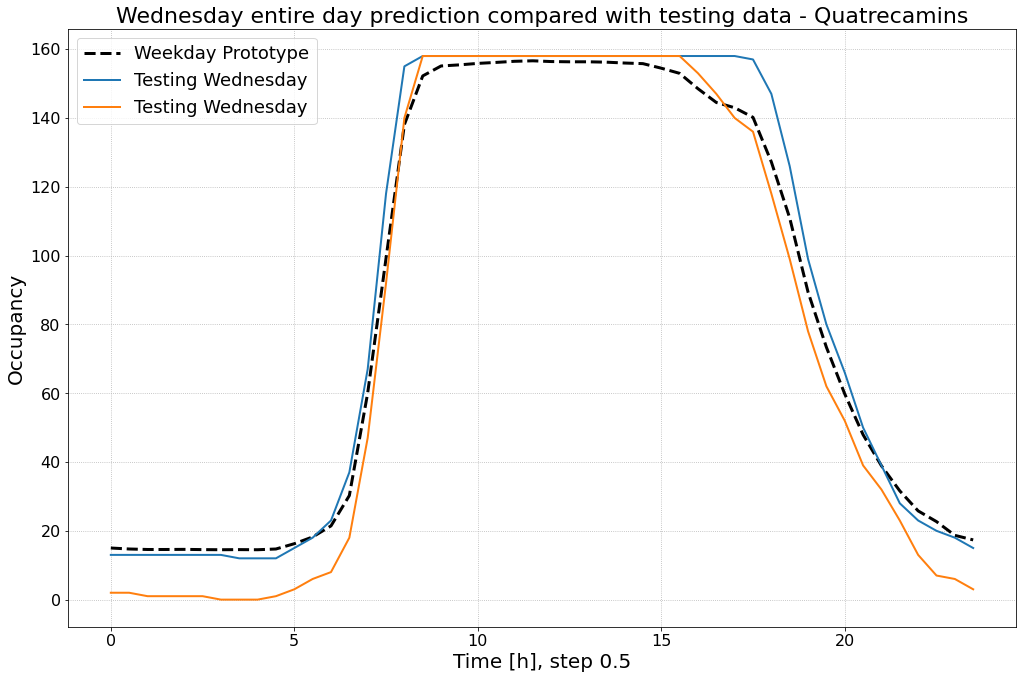

In [41]:
fig = plt.figure(figsize=(17,11))
plt.title('Wednesday entire day prediction compared with testing data - Quatrecamins', fontsize = 22)
plt.plot(time, Weekday_proto.values, linestyle='dashed', linewidth=3, color='black', label='Weekday Prototype')
plt.plot(time, testing_wednesdays[0], linewidth=2, label="Testing Wednesday")
plt.plot(time, testing_wednesdays[1], linewidth=2, label="Testing Wednesday")
# plt.plot(time, testing_wednesdays[3], linewidth=2, label="Testing Wednesday")
plt.grid(linestyle='dotted')
plt.legend(fontsize=18)
plt.xlabel('Time [h], step 0.5', fontsize=20)
plt.ylabel('Occupancy', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

#### Computing errors for 3 prototypes

In [42]:
def compute_testing_prop_error(testing_days, proto_data):
    errors = np.zeros(48)
    n_test_days = len(testing_days)
    proto = np.array(proto_data)
    
    for i in range(0, n_test_days):
        day = np.array(testing_days[i])
        er = np.array((np.absolute(proto - day)/max_value)*100)
        errors += er
    return errors/n_test_days

error_monday_stat = compute_testing_prop_error(testing_mondays, Weekday_proto.values)
error_tuesday_stat = compute_testing_prop_error(testing_tuesdays, Weekday_proto.values)
error_wednesday_stat = compute_testing_prop_error(testing_wednesdays, Weekday_proto.values)
error_thursday_stat = compute_testing_prop_error(testing_thursdays, Weekday_proto.values)
error_friday_stat = compute_testing_prop_error(testing_fridays, Friday_proto.values)
error_saturday_stat = compute_testing_prop_error(testing_saturdays, Weekend_proto.values)
error_sunday_stat = compute_testing_prop_error(testing_sundays, Weekend_proto.values)

5.089034558971267
4.65641952983725
5.754282198111311
8.412133313240908
14.854581072935503
7.620221287151666
10.658838348711766
______STDV________
2.6966050469377985
2.4630870642055305
3.9638536156473596
4.935663946350966
7.350356997580305
1.2576540628910386
0.8554147150989057


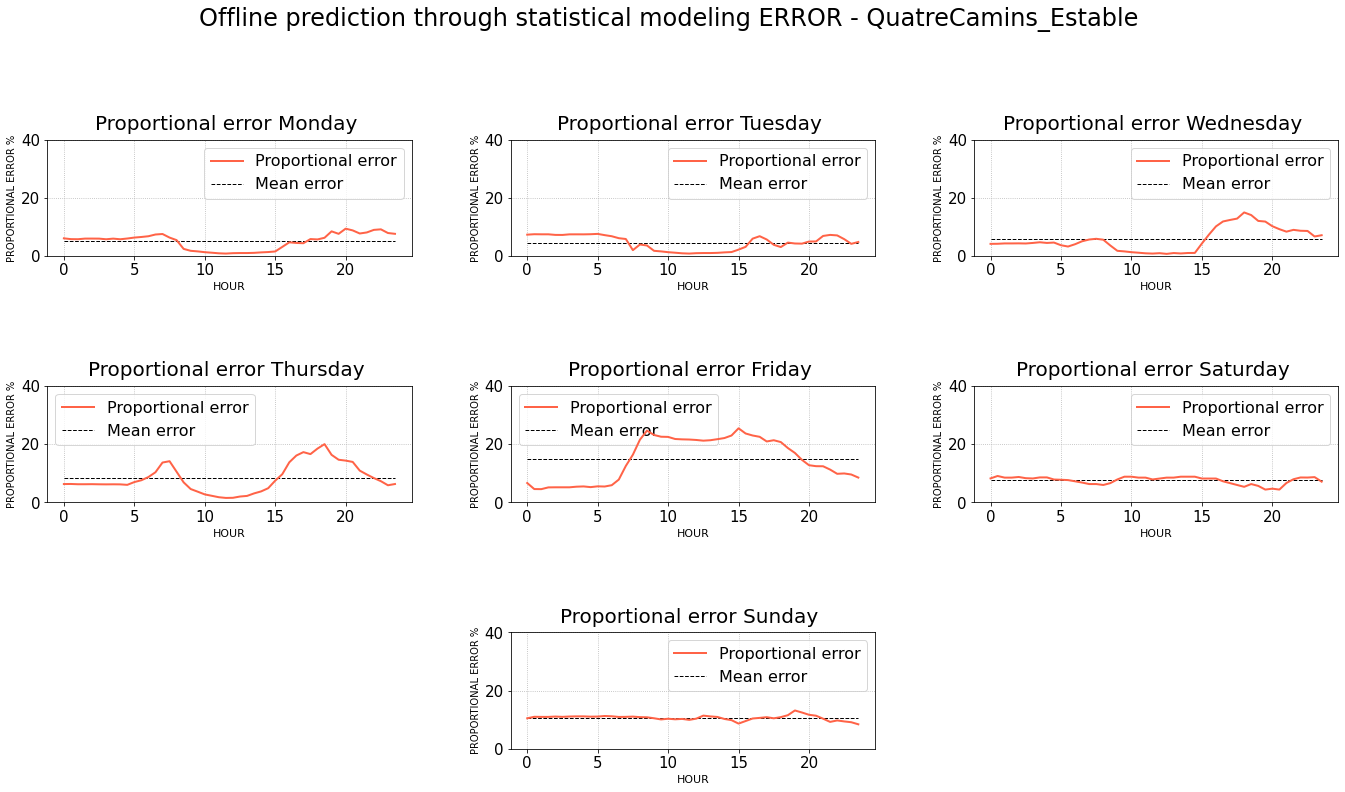

In [43]:
def subplotStatErr(fig, ax, axx, axy, x, error, mean, title, day ):
    ax[axx,axy].plot(x, error, color="tomato", linewidth=2, zorder=10, label='Proportional error')
    ax[axx,axy].plot(x, mean, linewidth=1, linestyle='--' ,color='black', label='Mean error')
    ax[axx,axy].grid(linestyle='dotted')
    ax[axx,axy].legend(loc='upper left', fontsize=10)
    ax[axx,axy].set_ylabel('Proportional error %', fontsize=20)
    ax[axx,axy].set_xlabel('Hours', fontsize=30)
    ax[axx,axy].set_title(title, pad=10, fontsize=20)
    ax[axx,axy].set_ylim((0,40))
    ax[axx,axy].legend(fontsize=16)
    ax[axx,axy].tick_params( labelsize=15)
    
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Offline prediction through statistical modeling ERROR - '+ current_parking, fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_stat)]*len(time)
subplotStatErr(fig, ax, 0, 0, time, error_monday_stat, mean_Monday, 
                 'Proportional error Monday ', 'Monday')

mean_Tuesday =  [np.mean(error_tuesday_stat)]*len(time)
subplotStatErr(fig, ax, 0, 1, time, error_tuesday_stat, mean_Tuesday, 
                 'Proportional error Tuesday ', 'Tuesday')

mean_Wednesday =  [np.mean(error_wednesday_stat)]*len(time)
subplotStatErr(fig, ax, 0, 2, time, error_wednesday_stat, mean_Wednesday, 
                 'Proportional error Wednesday ', 'Wednesday')

mean_Thursday =  [np.mean(error_thursday_stat)]*len(time)
subplotStatErr(fig, ax, 1, 0, time, error_thursday_stat, mean_Thursday, 
                 'Proportional error Thursday ', 'Thursday')

mean_Friday =  [np.mean(error_friday_stat)]*len(time)
subplotStatErr(fig, ax, 1, 1, time, error_friday_stat, mean_Friday, 
                 'Proportional error Friday ', 'Friday')

mean_Saturday =  [np.mean(error_saturday_stat)]*len(time)
subplotStatErr(fig, ax, 1, 2, time, error_saturday_stat, mean_Saturday, 
                 'Proportional error Saturday ', 'Saturday')

mean_Sunday =  [np.mean(error_sunday_stat)]*len(time)
subplotStatErr(fig, ax, 2, 1, time, error_sunday_stat, mean_Sunday, 
                 'Proportional error Sunday ', 'Sunday')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5.0)
for ax in ax.flat:
    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
    ax.set_xlabel('HOUR', fontsize=11)

print(mean_Monday[0])
print(mean_Tuesday[0])
print(mean_Wednesday[0])
print(mean_Thursday[0])
print(mean_Friday[0])
print(mean_Saturday[0])
print(mean_Sunday[0])

print('______STDV________')

print(np.std(error_monday_stat))
print(np.std(error_tuesday_stat))
print(np.std(error_wednesday_stat))
print(np.std(error_thursday_stat))
print(np.std(error_friday_stat))
print(np.std(error_saturday_stat))
print(np.std(error_sunday_stat))

(0.0, 30.0)

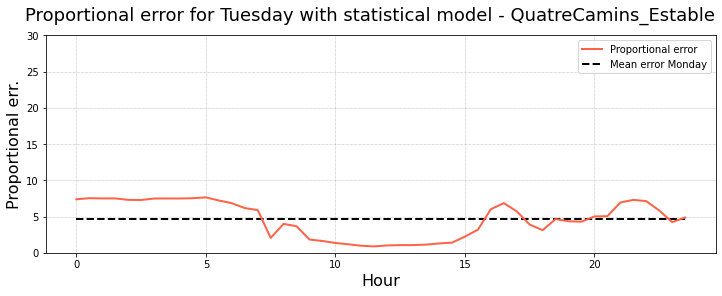

In [44]:
fig = plt.figure(figsize=(12,4))
fig.suptitle('Proportional error for Tuesday with statistical model - '+ current_parking, fontsize=18)
plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
plt.plot(real_tuesday.index.tolist(), error_tuesday_stat, color="tomato", linewidth=2, zorder=10, label='Proportional error')
plt.plot(real_tuesday.index.tolist(), mean_Tuesday, linewidth=2, linestyle='--' ,color='black', label='Mean error Monday')
plt.legend()
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Proportional err.', fontsize=16)
plt.ylim([0,30])

## NORMALIZATION

In [45]:
def Area_by_date(date):
    df = df_prediction_mean
    df_day = df[(df['Date'] == date)]
    day_occ = df_day['Occupancy_mod'].values
    Area = integrate.simps(day_occ)
    return Area


def df_normalization(occ, area):
    if area == 0:
        return occ
    return occ/area

def compute_min(date):
    df_day = df[(df['Date'] == date)]
    day_occ = df_day['Occupancy'].values
    return min(day_occ)


df_prediction_mean['Min_value'] = df_prediction_mean['Date'].apply(lambda x: compute_min(x))
df_mean_offset = df_prediction_mean.groupby(['Profile_3'], as_index=False).mean() 
df_mean_offset[['Profile_3','Min_value']]

friday_offset = df_mean_offset.iloc[0]['Min_value']
weekday_offset = df_mean_offset.iloc[1]['Min_value']
weekend_offset = df_mean_offset.iloc[2]['Min_value']

df_prediction_mean['Occupancy_mod'] = df_prediction_mean['Occupancy'] - df_prediction_mean['Min_value']



In [46]:
df_prediction_mean['Area'] = df_prediction_mean['Date'].apply(lambda x: Area_by_date(x))
df_prediction_mean['Normalized_occupancy'] = df_prediction_mean.apply(lambda x: df_normalization(x.Occupancy_mod, x.Area), axis=1)
df_normalized = df_prediction_mean[['Date', 'hour','MonthNumber', 'Normalized_occupancy', 'Weekday', 'Profile_3', 'Occupancy_mod', 'Area', 'Occupancy']].copy()


df_normalized

,Date,hour,MonthNumber,Normalized_occupancy,Weekday,Profile_3,Occupancy_mod,Area,Occupancy
0,2020-01-02,0.0,01,0.000437,Thursday,Weekday,1.0,2288.083333,44.0
1,2020-01-02,0.5,01,0.000437,Thursday,Weekday,1.0,2288.083333,44.0
2,2020-01-02,1.0,01,0.000437,Thursday,Weekday,1.0,2288.083333,44.0
3,2020-01-02,1.5,01,0.000000,Thursday,Weekday,0.0,2288.083333,43.0
4,2020-01-02,2.0,01,0.000000,Thursday,Weekday,0.0,2288.083333,43.0
...,...,...,...,...,...,...,...,...,...
3308,2020-03-15,22.0,03,0.031250,Sunday,Weekend,1.0,32.000000,1.0
3309,2020-03-15,22.5,03,0.000000,Sunday,Weekend,0.0,32.000000,0.0
3310,2020-03-15,23.0,03,0.000000,Sunday,Weekend,0.0,32.000000,0.0
3311,2020-03-15,23.5,03,0.000000,Sunday,Weekend,0.0,32.000000,0.0


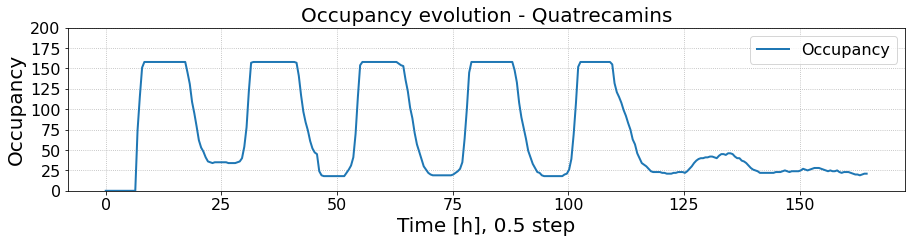

In [59]:
#starting_plot = df_normalized[df_normalized['Date']=='2020-02-10'].index[0]
starting_plot = df_normalized[df_normalized['Date']=='2020-02-10'].index[0]
#ending_plot = df_normalized[df_normalized['Date']=='2020-02-17'].index[0]
ending_plot = df_normalized[df_normalized['Date']=='2020-02-17'].index[0]

week = df_normalized.iloc[starting_plot:ending_plot]
week_values = week['Occupancy'].values
time = np.linspace(0,164.5,len(week))

fig, ax = plt.subplots(figsize=(15,3))
plt.plot(time, week_values, label='Occupancy', linewidth=2)
plt.title('Occupancy evolution - Quatrecamins', fontsize = 20)
plt.xlabel('Time [h], 0.5 step', fontsize = 20)
plt.ylabel('Occupancy', fontsize = 20)
plt.ylim([0,200])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='dotted')
plt.legend(fontsize=16)

In [48]:
def split_data(df, n_test_weeks, limit_date = None, from_end=True): 
    if(limit_date != None):
        init_test = df[df['Date']==limit_date].index[0];
        end_test = df.shape[0]
        test_domain = range(init_test, end_test)
        test_domain = list(test_domain)

    else:
        if(from_end == True):
            end_test = df.shape[0]
            week_domain = n_test_weeks*336
            init_test = end_test-week_domain
            test_domain = range(init_test, end_test)
            test_domain = list(test_domain)
            
        elif(from_end == False):
            week_domain = n_test_weeks*336
            init_test = 0
            end_test = week_domain
            test_domain = range(0,week_domain)
            test_domain = list(test_domain)
            
    test_df = df[init_test:end_test]
    training_df = df.drop(test_domain)
    return training_df, test_df

In [49]:
df_training, df_testing = split_data(df_normalized, 3)
df_testing

,Date,hour,MonthNumber,Normalized_occupancy,Weekday,Profile_3,Occupancy_mod,Area,Occupancy
2305,2020-02-22,0.5,02,0.001796,Saturday,Weekend,1.0,556.916667,1.0
2306,2020-02-22,1.0,02,0.000000,Saturday,Weekend,0.0,556.916667,0.0
2307,2020-02-22,1.5,02,0.001796,Saturday,Weekend,1.0,556.916667,1.0
2308,2020-02-22,2.0,02,0.001796,Saturday,Weekend,1.0,556.916667,1.0
2309,2020-02-22,2.5,02,0.000000,Saturday,Weekend,0.0,556.916667,0.0
...,...,...,...,...,...,...,...,...,...
3308,2020-03-15,22.0,03,0.031250,Sunday,Weekend,1.0,32.000000,1.0
3309,2020-03-15,22.5,03,0.000000,Sunday,Weekend,0.0,32.000000,0.0
3310,2020-03-15,23.0,03,0.000000,Sunday,Weekend,0.0,32.000000,0.0
3311,2020-03-15,23.5,03,0.000000,Sunday,Weekend,0.0,32.000000,0.0


In [50]:
df_training['Area'] = df_training['Date'].apply(lambda x: Area_by_date(x))
df_training

df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

# df_normalized

Weekday area:  3516.657738095238
Friday area:  3082.095238095238
Weekend area:  435.2142666666666


In [51]:
def get_days_normalized(dayname, df_):
    data_temp = df_[df_['Weekday'] == dayname] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Normalized_occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
    return days

def get_days_of_protos_normalized(proto_name, df_):
    data_temp = df_[df_['Profile_3'] == proto_name] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Normalized_occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
        
    return days

In [52]:
# ------------------------ NEW TESTING DATA -----------------------------
# these variables are arrays of days
testing_mondays_norm    = get_days_normalized("Monday", df_testing)
testing_tuesdays_norm   = get_days_normalized("Tuesday", df_testing)
testing_wednesdays_norm = get_days_normalized("Wednesday", df_testing)
testing_thursdays_norm  = get_days_normalized("Thursday", df_testing)
testing_fridays_norm    = get_days_normalized("Friday", df_testing)
testing_saturdays_norm  = get_days_normalized("Saturday", df_testing)
testing_sundays_norm    = get_days_normalized("Sunday", df_testing)

testing_mondays    = get_days("Monday", df_testing)
testing_tuesdays   = get_days("Tuesday", df_testing)
testing_wednesdays = get_days("Wednesday", df_testing)
testing_thursdays  = get_days("Thursday", df_testing)
testing_fridays    = get_days("Friday", df_testing)
testing_saturdays  = get_days("Saturday", df_testing)
testing_sundays    = get_days("Sunday", df_testing)

In [53]:
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
# for ii in range(len(training_weekdays_norm)):
#     plt.plot(time,training_weekdays_norm[ii])

## MATHEMATICAL MODEL - CDF Subtraction

In [54]:
# ********************************************** WEEKDAY *************************************************************
from scipy.special import gamma, factorial
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)

def generate_cdf(data):
    cumulative=[0]
    for ii in range(1,len(data)):
        cumulative.append(sum(data[:ii]))
    return cumulative/sum(data)

def gam(x,b,a):
     return ((b**a)*((x)**(a-1))*np.exp(-b*(x)))/(gamma(a))


training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekends_norm = training_weekends_norm[:-1]
# t = []
# for i in range(0,len(training_weekends_norm)):
#     if training_weekends_norm[i].mean() != 0:
#         t.append(training_weekends_norm[i])
        
# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)

def model_weekdays(params): 
    beta1 = params[0]
    alpha1 = params[1]
    beta2 = params[2]
    alpha2 = params[3]
    scale = params[4]
    error = 0
    # make gamma for arribals
    arrival_pdf = gam(time, beta1, alpha1)
    # make gamma for departures
    departure_pdf = gam(time, beta2, alpha2)
    # compute CDF for arribals
    arrival_cdf = generate_cdf(arrival_pdf)
    # compute CDF for departures
    departure_cdf = generate_cdf(departure_pdf)
    res = np.array(arrival_cdf) - np.array(departure_cdf)
    res = res*scale
    
    for ii in range(0,wd_length):
        day = training_weekdays_norm[ii]
        error += mean_squared_error(res, day)
    return error


# params order = a1, b1, a2, b2, rescale
parameters = np.array([ 2 , 20, 5, 80, 0.02])
optimal_params_weekday = minimize(model_weekdays, parameters, method='Nelder-Mead', tol=0.01)

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
weekday_math_params = optimal_params_weekday.x
weekday_math_params

In [ ]:
time2 = np.linspace(0,23.5,48)
gam1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
gam2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

cdf1_wd = generate_cdf(gam1_wd)
cdf2_wd = generate_cdf(gam2_wd)
resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd*optimal_params_weekday.x[4]
fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS (Quatrecamins)", fontsize=26)
plt.plot(time2, gam1_wd, label="Probability that a slot is occupied")
plt.plot(time2, gam2_wd,  label="Probability that a slot gets free")
plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
plt.plot(time2, cdf2_wd, label="Cummulative probability departure")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left")


In [ ]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - WEEKDAYS", fontsize=26)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
for i in range(0,len(training_weekdays_norm)):
    plt.plot(time, training_weekdays_norm[i], linewidth=0.45)

plt.legend(fontsize=16, loc="upper left")

### FRIDAYS

Fridays for 4 camins does not work due to 0 in division during the minimization - ToDo

In [ ]:
# def model_fridays(params): 
#     beta1 = params[0]
#     alpha1 = params[1]
#     beta2 = params[2]
#     alpha2 = params[3]
#     scale = params[4]
#     error = 0
#     # make gamma for arribals
#     arrival_pdf = gam(time, beta1, alpha1)
#     # make gamma for departures
#     departure_pdf = gam(time, beta2, alpha2)
#     # compute CDF for arribals
#     arrival_cdf = generate_cdf(arrival_pdf)
#     # compute CDF for departures
#     departure_cdf = generate_cdf(departure_pdf)
#     res = np.array(arrival_cdf) - np.array(departure_cdf)
#     res = res*scale
    
#     for ii in range(0,f_length):
#         day = training_fridays_norm[ii]
#         error += mean_squared_error(res, day)
#     return error

# # params order = a1, b1, a2, b2
# parameters = np.array([ 2 , 20, 5, 80, 0.02])
# optimal_params_friday = minimize(model_fridays, parameters, method='Nelder-Mead', tol=0.01)

In [ ]:
# optimal_params_friday.x
# friday_math_params = optimal_params_friday.x

In [ ]:

# gam1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
# gam2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])

# cdf1_fri = generate_cdf(gam1_fri)
# cdf2_fri = generate_cdf(gam2_fri)
# resta = np.array(cdf1_fri) - np.array(cdf2_fri)
# prototype_math_friday = resta*optimal_params_friday.x[4]
# fig = plt.figure(figsize=(18,10))
# fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKDAYS", fontsize=26)
# plt.plot(time, cdf1_fri, label="CDF Slot occupied")
# plt.plot(time, cdf2_fri, label="CDF Slot free")
# plt.plot(time, gam1_fri, label="Probability that a slot is occupied")
# plt.plot(time, gam2_fri,  label="Probability that a slot gets free")
# plt.grid(linestyle='dotted')
# plt.xlabel("Time [h]", fontsize=18)
# plt.ylabel("PDF & CDF", fontsize=18)
# plt.yticks(fontsize=18)
# plt.xticks(fontsize=18)
# plt.legend(fontsize=16, loc="upper left")

# plt.legend(fontsize=16)

In [ ]:
# fig = plt.figure(figsize=(18,10))
# fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS", fontsize=26)
# plt.grid(linestyle='dotted')
# plt.xlabel("Time [h]", fontsize=18)
# plt.ylabel("PDF & CDF", fontsize=18)
# plt.yticks(fontsize=18)
# plt.xticks(fontsize=18)
# plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
# for i in range(0,len(training_fridays_norm)):
#     plt.plot(time, training_fridays_norm[i], linewidth=0.45)
# plt.legend(fontsize=16)

### WEEKENDS

In [ ]:
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekends_norm = training_weekends_norm[:-1]
t = []
for i in range(0,len(training_weekends_norm)):
    if training_weekends_norm[i].mean() != 0:
        t.append(training_weekends_norm[i])
        
training_weekends_norm = t
we_length = len(t)
def model_weekends(params): 
    beta1 = params[0]
    alpha1 = params[1]
    beta2 = params[2]
    alpha2 = params[3]
    scale = params[4]
    error = 0
    # make gamma for arribals
    arrival_pdf = gam(time, beta1, alpha1)
    # make gamma for departures
    departure_pdf = gam(time, beta2, alpha2)
    # compute CDF for arribals
    arrival_cdf = generate_cdf(arrival_pdf)
    # compute CDF for departures
    departure_cdf = generate_cdf(departure_pdf)
    res = np.array(arrival_cdf) - np.array(departure_cdf)
    res = res*scale
    
    for ii in range(0,we_length):
        day = training_weekends_norm[ii]
        error += mean_squared_error(res, day)
    return error

# params order = a1, b1, a2, b2
parameters = np.array([ 2 , 20, 5, 80, 2])
optimal_params_weekend = minimize(model_weekends, parameters, method='Nelder-Mead', tol=0.01)

In [ ]:
weekend_math_params = optimal_params_weekend.x
optimal_params_weekend.x

In [ ]:
gam1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
gam2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])

cdf1_we = generate_cdf(gam1_we)
cdf2_we = generate_cdf(gam2_we)
resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we*(optimal_params_weekend.x[4]*1)
fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS", fontsize=26)
plt.plot(time, cdf1_we, label="CDF Slot occupied")
plt.plot(time, cdf2_we, label="CDF Slot free")
plt.plot(time, gam1_we, label="Probability that a slot is occupied")
plt.plot(time, gam2_we,  label="Probability  a slot gets free")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left")

plt.legend(fontsize=16)

In [ ]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - WEEKENDS", fontsize=26)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time, prototype_math_weekend, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
for i in range(0,len(training_weekends_norm)):
    plt.plot(time, training_weekends_norm[i], linewidth=0.45)
plt.legend(fontsize=16)

In [ ]:
gammix_weekday_n = prototype_math_weekday
# gammix_friday_n = prototype_math_friday
gam1_weekend_n = prototype_math_weekend

In [ ]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [Probability Normalized Mathematical] - ' + current_parking, fontsize=20)

# for ii in range(len(training_weekdays_norm)):
#     ax[0].plot(time,training_weekdays_norm[ii], linewidth='0.5')
ax[0].plot(time2, gammix_weekday_n, linewidth=2, color= 'green', label='Mathematical Weekday fit')
ax[0].set_ylim([0,0.06])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays_norm)):
#     ax[1].plot(time,training_fridays_norm[ii], linewidth='0.5')
# ax[1].plot(time2, gammix_friday_n, linewidth=2, color= 'green', label='Mathematical Friday fit')
# ax[1].set_ylim([0,0.06])
# ax[1].grid(linestyle='dotted')
# ax[1].legend(fontsize=9)
# ax[1].set_xlabel('Time (hour)')
# ax[1].set_ylabel('Probability')

# for ii in range(len(training_weekends_norm)):
#      ax[2].plot(time,training_weekends_norm[ii], linewidth='0.5')
ax[2].plot(time2, gam1_weekend_n, linewidth=2, color='green', label='Mathematical Weekend wave')
ax[2].set_ylim([0,0.06])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability')

In [ ]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [Probability Normalized Mathematical] - ' + current_parking, fontsize=20)

# for ii in range(len(training_weekdays_norm)):
#     ax[0].plot(time,training_weekdays_norm[ii], linewidth='0.5')
ax[0].plot(time, gammix_weekday_n, linewidth=2, color= 'green', label='Mathematical Weekday fit')
ax[0].set_ylim([0,0.06])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays_norm)):
#     ax[1].plot(time,training_fridays_norm[ii], linewidth='0.5')
# ax[1].plot(time, gammix_friday_n, linewidth=2, color= 'green', label='Mathematical Friday fit')
# ax[1].set_ylim([0,0.06])
# ax[1].grid(linestyle='dotted')
# ax[1].legend(fontsize=9)
# ax[1].set_xlabel('Time (hour)')
# ax[1].set_ylabel('Probability')

# CHECK THIS
Area = integrate.simps(gam1_weekend_n) 
gam1_weekend_n = gam1_weekend_n/Area

# for ii in range(len(training_weekends_norm)):
#      ax[2].plot(time,training_weekends_norm[ii], linewidth='0.5')
ax[2].plot(time, gam1_weekend_n, linewidth=2, color='green', label='Mathematical Weekend wave')
ax[2].set_ylim([0,0.06])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability')

In [ ]:
sum(gam1_weekend_n)

In [ ]:
#**************************************WEEKDAY************************************
gammix_weekday = gammix_weekday_n*weekday_area + weekday_offset

#**************************************FRIDAY************************************
# gammix_friday = gammix_friday_n*friday_area + friday_offset

#**************************************WEEKEND************************************
gam1_weekend = gam1_weekend_n*weekend_area + weekend_offset 

Text(0, 0.5, 'Probability')

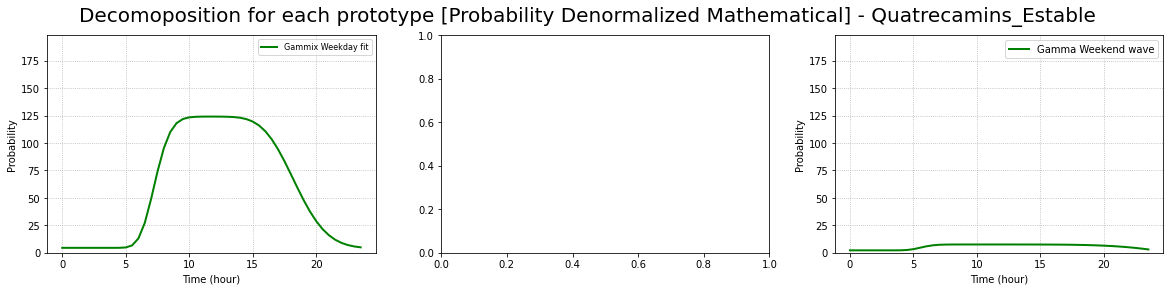

In [185]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [Probability Denormalized Mathematical] - ' + current_parking , fontsize=20)

# for ii in range(len(training_weekdays)):
#     ax[0].plot(time,training_weekdays[ii], linewidth='0.5')
ax[0].plot(time, gammix_weekday, linewidth=2, color= 'green', label='Gammix Weekday fit')
ax[0].set_ylim([0,axis_ylim])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays)):
#     ax[1].plot(time,training_fridays[ii], linewidth='0.5')
# ax[1].plot(time, gammix_friday, linewidth=2, color= 'green', label='Gammix Friday fit')
# ax[1].set_ylim([0,axis_ylim])
# ax[1].grid(linestyle='dotted')
# ax[1].legend(fontsize=9)
# ax[1].set_xlabel('Time (hour)')
# ax[1].set_ylabel('Probability')

# for ii in range(len(training_weekends)):
#     ax[2].plot(time,training_weekends[ii], linewidth='0.5')
ax[2].plot(time, gam1_weekend, linewidth=2, color='green', label='Gamma Weekend wave')
ax[2].set_ylim([0,axis_ylim])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability')
# ax[2].set_yticks([0,0.005,0.01])
# ax[2].set_yticks(["0","0.05","0.1"])

### Comparing normalized mathematical fitted prototype with testing data

In [186]:
def subplot_training(fig, ax, xx, yy, proto_data, test_days, day, proto_name): 
    ax[xx,yy].plot(time, proto_data, linewidth=3, linestyle='dashed', label= proto_name + ' prediction')
    ax[xx,yy].legend(fontsize=16)
    for i in range(0, len(test_days)): 
        ax[xx, yy].plot(time, test_days[i], linewidth=1, label='Testing ' + day )
    ax[xx,yy].grid(linestyle='dotted')
    ax[xx,yy].set_ylim(-2,axis_ylim)
    ax[xx,yy].set_xlabel('Time (hours)', fontsize=16)
    ax[xx,yy].set_ylabel('Occupancy', fontsize=16)


### Denormalization / Rescaling

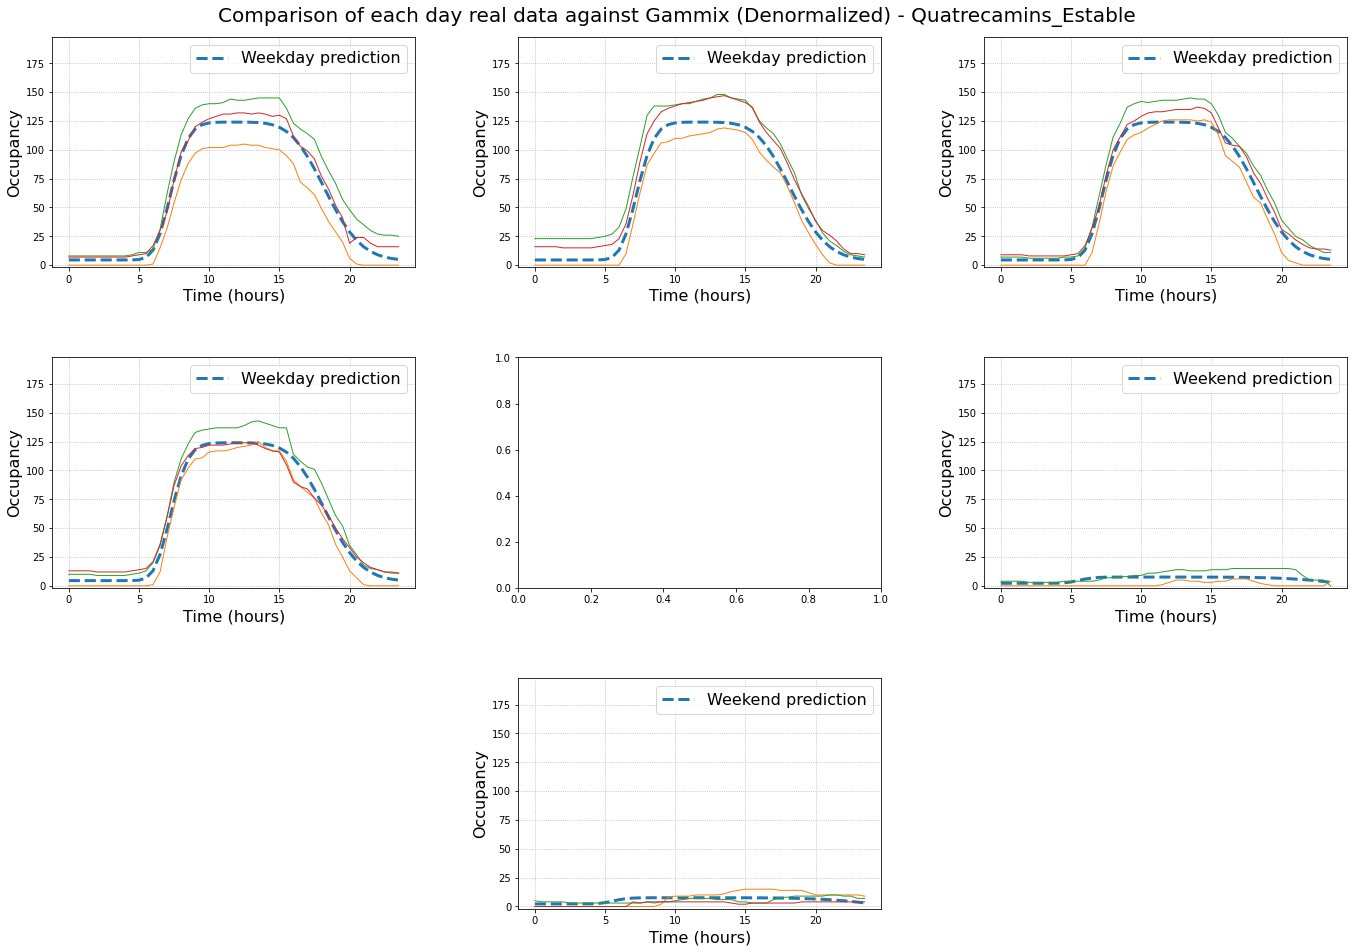

In [187]:
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(14)
fig.suptitle('Comparison of each day real data against Gammix (Denormalized) - ' + current_parking, fontsize=20)

gammix_weekday = gammix_weekday_n*weekday_area + weekday_offset
# gammix_friday = gammix_friday_n*friday_area + friday_offset
gam1_weekend = gam1_weekend_n*weekend_area + weekend_offset 

subplot_training(fig, ax, 0, 0, gammix_weekday, testing_mondays, 'Monday', 'Weekday')
subplot_training(fig, ax, 0, 1, gammix_weekday, testing_tuesdays, 'Tuesday', 'Weekday')
subplot_training(fig, ax, 0, 2, gammix_weekday, testing_wednesdays, 'Wednesday', 'Weekday')
subplot_training(fig, ax, 1, 0, gammix_weekday, testing_thursdays, 'Thursday', 'Weekday')
# subplot_training(fig, ax, 1, 1, gammix_friday, testing_fridays, 'Friday', 'Friday')
subplot_training(fig, ax, 1, 2, gam1_weekend, testing_saturdays, 'Saturday', 'Weekend')
subplot_training(fig, ax, 2, 1, gam1_weekend, testing_sundays, 'Sunday', 'Weekend')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5.0)

IndexError: list index out of range

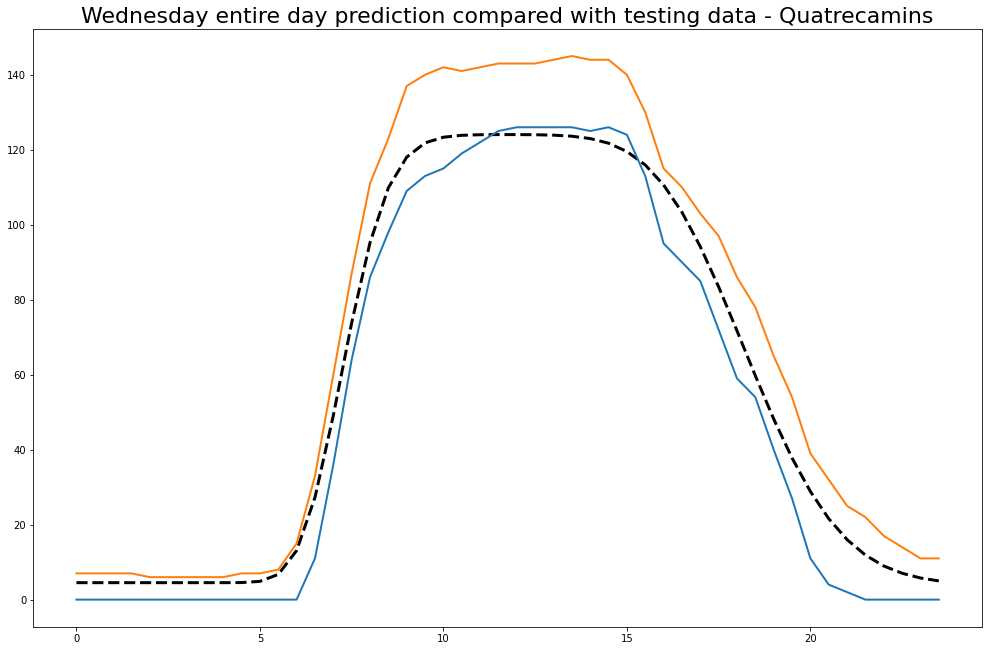

In [188]:
fig = plt.figure(figsize=(17,11))
plt.title('Wednesday entire day prediction compared with testing data - Quatrecamins', fontsize = 22)
plt.plot(time, gammix_weekday, linestyle='dashed', linewidth=3, color='black', label='Weekday Gammix Prototype')
plt.plot(time, testing_wednesdays[0], linewidth=2, label="Testing Wednesday")
plt.plot(time, testing_wednesdays[1], linewidth=2, label="Testing Wednesday")
plt.plot(time, testing_wednesdays[3], linewidth=2, label="Testing Wednesday")
plt.grid(linestyle='dotted')
plt.legend(fontsize=18)
plt.xlabel('Time [h], step 0.5', fontsize=20)
plt.ylabel('Occupancy', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

In [56]:
def compute_testing_prop_error(testing_days, proto_data):
    errors = np.zeros(48)
    n_test_days = len(testing_days)
    proto = np.array(proto_data)
    
    for i in range(0, n_test_days):
        day = np.array(testing_days[i])
        er = np.array((np.absolute(proto - day)/max_value)*100)
        errors += er
    return errors/n_test_days

error_monday_gammix = compute_testing_prop_error(testing_mondays, gammix_weekday)
error_tuesday_gammix = compute_testing_prop_error(testing_tuesdays, gammix_weekday)
error_wednesday_gammix = compute_testing_prop_error(testing_wednesdays, gammix_weekday)
error_thursday_gammix = compute_testing_prop_error(testing_thursdays, gammix_weekday)
# error_friday_gammix = compute_testing_prop_error(testing_fridays, gammix_friday)
error_saturday_gammix = compute_testing_prop_error(testing_saturdays, gam1_weekend)
error_sunday_gammix = compute_testing_prop_error(testing_sundays, gam1_weekend)

def subplotGammixErr(fig, ax, axx, axy, x, error, mean, title, day ):
    ax[axx,axy].plot(x, error, color="tomato", linewidth=2, zorder=10, label='Proportional error')
    ax[axx,axy].plot(x, mean, linewidth=1, linestyle='--' ,color='black', label='Mean error Monday')
    ax[axx,axy].grid(linestyle='dotted')
    ax[axx,axy].set_ylabel('Proportional error %', fontsize=20)
    ax[axx,axy].set_xlabel('Hours', fontsize=20)
    ax[axx,axy].set_title(title , fontsize=20, pad=10)
    ax[axx,axy].set_ylim((0,40))
    ax[axx,axy].legend(fontsize=16)
    ax[axx,axy].tick_params( labelsize=15)

    
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Offline prediction through mathematical modeling ERROR - Quatrecamins (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_gammix)]*len(time)
subplotGammixErr(fig, ax, 0, 0, time, error_monday_gammix, mean_Monday, 
                 'Proportional error Monday ', 'Monday')

mean_Tuesday =  [np.mean(error_tuesday_gammix)]*len(time)
subplotGammixErr(fig, ax, 0, 1, time, error_tuesday_gammix, mean_Tuesday, 
                 'Proportional error Tuesday ', 'Tuesday')

mean_Wednesday =  [np.mean(error_wednesday_gammix)]*len(time)
subplotGammixErr(fig, ax, 0, 2, time, error_wednesday_gammix, mean_Wednesday, 
                 'Proportional error Wednesday ', 'Wednesday')

mean_Thursday =  [np.mean(error_thursday_gammix)]*len(time)
subplotGammixErr(fig, ax, 1, 0, time, error_thursday_gammix, mean_Thursday, 
                 'Proportional error Thursday ', 'Thursday')

# mean_Friday =  [np.mean(error_friday_gammix)]*len(time)
# subplotGammixErr(fig, ax, 1, 1, time, error_friday_gammix, mean_Friday, 
#                  'Proportional error Friday ', 'Friday')

mean_Saturday =  [np.mean(error_saturday_gammix)]*len(time)
subplotGammixErr(fig, ax, 1, 2, time, error_saturday_gammix, mean_Saturday, 
                 'Proportional error Saturday ', 'Saturday')

mean_Sunday =  [np.mean(error_sunday_gammix)]*len(time)
subplotGammixErr(fig, ax, 2, 1, time, error_sunday_gammix, mean_Sunday, 
                 'Proportional error Sunday ', 'Sunday')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5.0)
for ax in ax.flat:
    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
    ax.set_xlabel('HOUR', fontsize=11)
    
print(mean_Monday[0])
print(mean_Tuesday[0])
print(mean_Wednesday[0])
print(mean_Thursday[0])
print(mean_Friday[0])
print(mean_Saturday[0])
print(mean_Sunday[0])

print('______STDV________')

print(np.std(error_monday_gammix))
print(np.std(error_tuesday_gammix))
print(np.std(error_wednesday_gammix))
print(np.std(error_thursday_gammix))
# print(np.std(error_friday_gammix))
print(np.std(error_saturday_gammix))
print(np.std(error_sunday_gammix))


NameError: name 'gammix_weekday' is not defined

### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [ ]:
# Plotting methods to reduce cell dimension

def real_timing_predition(fig, ax, axx, day, gammix_proto, real_day, scaled_proto, Prototype, limit_hour):
    fig.suptitle('Real time prediction Scaling mathematical and mean proto for Testing ' + day, fontsize='18')
    ax[axx].plot(time, real_day.values, linestyle='dashdot', linewidth=2, label='Real ' + day)
    ax[axx].plot(time, gammix_proto,'--',color='grey', label='Gammix prototype (no scaled)')
    ax[axx].plot(time, scaled_proto, color='green', linewidth=2, label='Gammix scaled proto')
    ax[axx].plot(time, Prototype, color='orange', linewidth=2, label='Stat. scaled proto')
    ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='Limit hour ')
    ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2, label='Known window')
    ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx].legend(fontsize=9)
    ax[axx].set_xlabel('Hour', fontsize=14)
    ax[axx].set_ylabel('Occupancy', fontsize=14)

def errors_plotting(fig, ax, axx, scaled_proto, Prototype, real_day, day, limit_hour):
    #Computing Errors
    limit_hour = limit_hour*2
    gammix_scaled_error = (np.absolute((np.array(scaled_proto) - np.array(real_day.values)))/max_value)*100
    mean_scaled_error = (np.absolute((np.array(Prototype) - np.array(real_day.values)))/max_value)*100

    gammix_s_error_mean = [np.mean(gammix_scaled_error[limit_hour:])]*len(gammix_scaled_error)
    mean_s_error_mean = [np.mean(mean_scaled_error[limit_hour:])]*len(mean_scaled_error)

    #Second plot
#     time = time[limit_hour:]
    ax[axx].plot(time[limit_hour:], gammix_scaled_error[limit_hour:], color='tomato', label='Math scaling error')
    ax[axx].plot(time[limit_hour:],gammix_s_error_mean[limit_hour:], '--',color='tomato', label='Mean proportional error Math')
    ax[axx].plot(time[limit_hour:],mean_scaled_error[limit_hour:], color='blueviolet', label='Mean scaling error')
    ax[axx].plot(time[limit_hour:],mean_s_error_mean[limit_hour:], '--',color='blueviolet', label='Mean proportional error Mean')
    ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx].axvline(x=limit_hour/2, linestyle='--', color='grey', linewidth=2, label='Limit hour ')
    ax[axx].axvspan(0, limit_hour/2, facecolor='grey', alpha=0.2, label='Known window', zorder=4)
    ax[axx].legend()
    ax[axx].set_ylim([0,20])
    ax[axx].set_xlabel('Hour', fontsize=14)
    ax[axx].set_ylabel('Proportional error (%)', fontsize=14)

    print('Real ' + day + ' scaled prtotype error: ', round(100*mean_s_error_mean[0])/100, '%')
    print('Real ' + day + ' scaled prtotype STDV: ', np.std(mean_scaled_error[limit_hour:]))

    print('Real ' + day + ' scaled Math error: ', round(100*gammix_s_error_mean[0])/100, '%')
    print('Real ' + day + ' scaled Math STDV: ', np.std(gammix_scaled_error[limit_hour:]))
    print('_____________________________________________________________')

def get_scaling_factor(limit_hour, test_day, proto):
    if limit_hour < 6:
        return 1
    index = limit_hour*2
    current_real_data = test_day.values[index]
    proto_value = proto[index]
    scaling = current_real_data/proto_value
    return scaling

#### MONDAY

In [ ]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_mondays
limit_hour = 16
day = 'Monday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto, limit_hour)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    

#### TUESDAY

In [ ]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_tuesdays
limit_hour = 10
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto, limit_hour)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    

### WEDNESDAY

In [ ]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_wednesdays
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto, limit_hour)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    

### THURSDAY

In [57]:
statistic_proto = hist_weekday_proto
gammix_proto = gammix_weekday
t_days = testing_thursdays
limit_hour = 13
day = 'Thursday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto, limit_hour)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    

NameError: name 'gammix_weekday' is not defined

### FRIDAY

In [195]:
# statistic_proto = hist_friday_proto
# gammix_proto = gammix_friday
# t_days = testing_fridays
# limit_hour = 16
# day = 'Friday'
# # Negative values to 0
# for i in range(0,len(gammix_proto)):
#     if gammix_proto[i] < 0:
#         gammix_proto[i] = 0

# for i in range(0,len(t_days)):
#     gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
#     stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
#     scaled_gamm_proto = gammix_proto * gamm_scaling
#     scaled_stat_proto = hist_weekday_proto.values * stat_scaling
#     fig, ax = plt.subplots(1, 2)
#     fig.set_figwidth(20)
#     fig.set_figheight(6)
#     axx=0;
#     real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto, limit_hour)
#     axx=1;
#     errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    

### WEEKEND

### SATURDAY

Real Saturday scaled prtotype error:  0.65 %
Real Saturday scaled prtotype STDV:  0.5820589463283137
Real Saturday scaled Math error:  1.29 %
Real Saturday scaled Math STDV:  0.5610565397417677
_____________________________________________________________
Real Saturday scaled prtotype error:  3.26 %
Real Saturday scaled prtotype STDV:  2.1881364950707822
Real Saturday scaled Math error:  1.3 %
Real Saturday scaled Math STDV:  0.7678419602642119
_____________________________________________________________


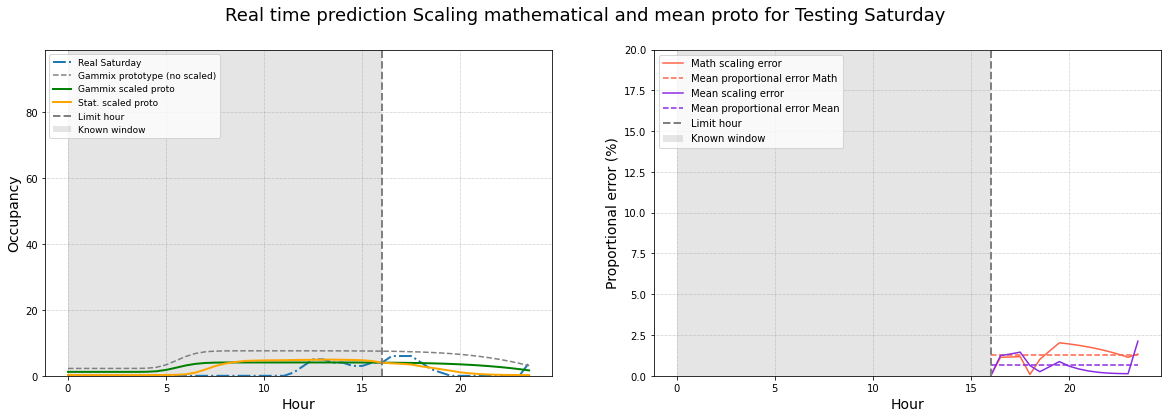

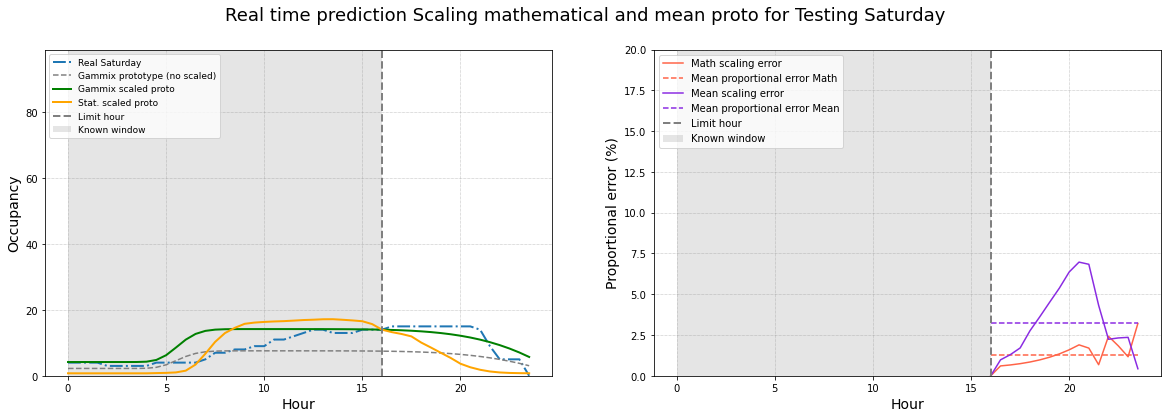

In [196]:
statistic_proto = hist_weekend_proto
gammix_proto = gam1_weekend
t_days = testing_saturdays
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto, limit_hour)
    ax[0].set_ylim([0,axis_ylim/2])
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    

### SUNDAY

Real Sunday scaled prtotype error:  3.98 %
Real Sunday scaled prtotype STDV:  1.5263804301833714
Real Sunday scaled Math error:  2.07 %
Real Sunday scaled Math STDV:  0.8532513070892822
_____________________________________________________________
Real Sunday scaled prtotype error:  2.68 %
Real Sunday scaled prtotype STDV:  1.8218882835272765
Real Sunday scaled Math error:  1.69 %
Real Sunday scaled Math STDV:  0.9854017932593907
_____________________________________________________________
Real Sunday scaled prtotype error:  1.07 %
Real Sunday scaled prtotype STDV:  0.8418917247652846
Real Sunday scaled Math error:  0.58 %
Real Sunday scaled Math STDV:  0.35123989832150365
_____________________________________________________________


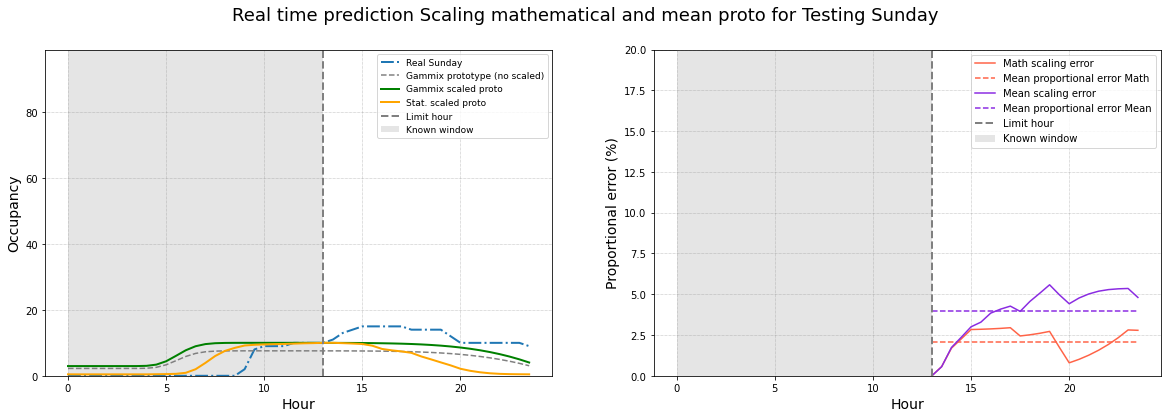

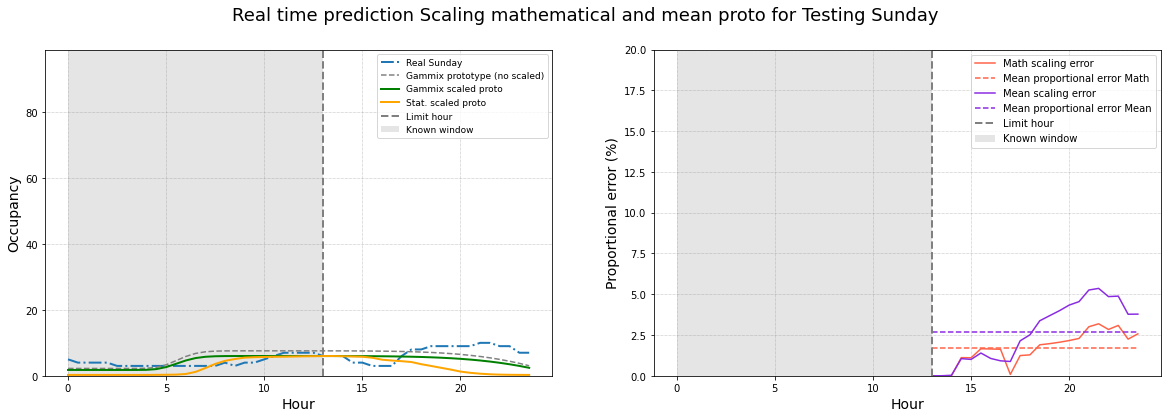

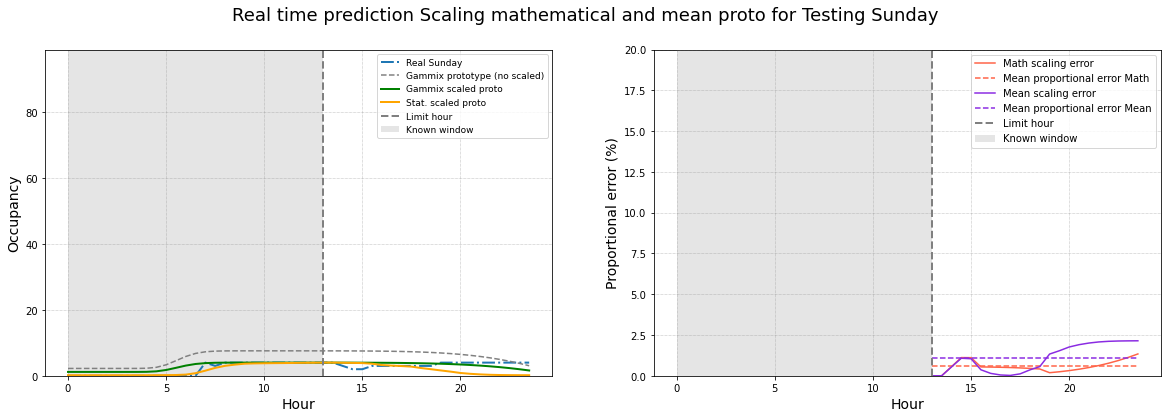

In [197]:
statistic_proto = hist_weekend_proto
gammix_proto = gam1_weekend
t_days = testing_sundays
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(gammix_proto)):
    if gammix_proto[i] < 0:
        gammix_proto[i] = 0

for i in range(0,len(t_days)):
    gamm_scaling = get_scaling_factor(limit_hour, t_days[i], gammix_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_gamm_proto = gammix_proto * gamm_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, gammix_proto, t_days[i], scaled_gamm_proto, scaled_stat_proto, limit_hour)
    ax[0].set_ylim([0,axis_ylim/2])
    axx=1;
    errors_plotting(fig, ax, axx, scaled_gamm_proto, scaled_stat_proto, t_days[i], day, limit_hour)

# Store protos, params, areas and offsets

In [198]:
# df_prototypes = pd.read_csv('data/prototypes_new.csv')
# index = 0

# weekday_gammix_params = ','.join(str(e) for e in list(res_weekday.x))
# friday_gammix_params  = ','.join(str(e) for e in list(res_friday.x))
# weekend_gammix_params = ','.join(str(e) for e in list(res_weekend.x))

# weekday_mean_area = weekday_area
# friday_mean_area  = friday_area
# weekend_mean_area = weekend_area

# weekday_mean_offset = weekday_offset
# friday_mean_offset  = friday_offset
# weekend_mean_offset = weekend_offset

# total_wave_weekday_s = ','.join(str(e) for e in gammix_weekday.tolist())
# total_wave_weekend_s = ','.join(str(e) for e in gam1_weekend.tolist())
# total_wave_friday_s  = ','.join(str(e) for e in gammix_friday.tolist())

# historical_weekday_s = ','.join(str(e) for e in hist_weekday_proto.tolist())
# historical_weekend_s = ','.join(str(e) for e in hist_weekend_proto.tolist())
# historical_friday_s  = ','.join(str(e) for e in hist_friday_proto.tolist())


# df_prototypes.at[index,'Gammix_weekday_proto'] = total_wave_weekday_s
# df_prototypes.at[index,'Gammix_friday_proto']  = total_wave_friday_s
# df_prototypes.at[index,'Gammix_weekend_proto'] = total_wave_weekend_s

# df_prototypes.at[index,'Gammix_weekday_params'] = weekday_gammix_params
# df_prototypes.at[index,'Gammix_friday_params']  = friday_gammix_params
# df_prototypes.at[index,'Gammix_weekend_params'] = weekend_gammix_params

# df_prototypes.at[index,'Gammix_weekday_area'] = weekday_mean_area
# df_prototypes.at[index,'Gammix_friday_area']  = friday_mean_area
# df_prototypes.at[index,'Gammix_weekend_area'] = weekend_mean_area

# df_prototypes.at[index,'Gammix_weekday_offset'] = weekday_mean_offset
# df_prototypes.at[index,'Gammix_friday_offset']  = friday_mean_offset
# df_prototypes.at[index,'Gammix_weekend_offset'] = weekend_mean_offset

# df_prototypes.at[index,'Historical_weekday_proto'] = historical_weekday_s
# df_prototypes.at[index,'Historical_weekend_proto'] = historical_weekend_s
# df_prototypes.at[index,'Historical_friday_proto']  = historical_friday_s

# df_prototypes.to_csv("data/final_prototypes.csv", index=False)
# df_prototypes

In [199]:
# How to read the prorotypes: 
# string = exportable_df.at[0,'Gammix_weekday_proto']
# list_of_strings = string.split(',')
# final_list = list(np.float_(list_of_strings))

In [200]:
# import pandas as pd
# df_prototypes_2 = pd.read_csv('data/prototypes_new.csv')
# new_row = {'Location':'Cerdanyola'}
# #append row to the dataframe
# df_prototypes_2 = df_prototypes_2.append(new_row, ignore_index=True)
# df_prototypes_2

In [201]:
# df_prototypes_2.to_csv("data/prototypes_new.csv", index=False)
# day = 'Monday'
# date = '2020-02-24'
# real_day = mean_of_day(day,date)
# real_day.values

In [202]:
# hist_friday_proto.tolist()